# Analysis and Geospatial visualizing

## Load the data

In [37]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("PreliminaryAnalysis").getOrCreate()

# Define the paths to the Parquet files
parquet_dir = '../data/curated/'

# Load the Parquet files
combined_sdf = spark.read.parquet(parquet_dir + 'yellow_hvfhv_sdf.parquet')
yellow_taxi_sdf_full = spark.read.parquet(parquet_dir + 'yellow_taxi_sdf_full.parquet')
hvfhv_sdf_full = spark.read.parquet(parquet_dir + 'hvfhv_sdf_full.parquet')

# Show the first few rows of each DataFrame to verify
combined_sdf.show(5)
yellow_taxi_sdf_full.show(5)
hvfhv_sdf_full.show(5)

+----------+-----------+------------+-------------------+
|      date|hour_bucket|PULocationID|market_share_yellow|
+----------+-----------+------------+-------------------+
|2023-11-01|          0|           7| 0.7326007326007326|
|2023-11-01|          0|          23|                0.0|
|2023-11-01|          0|          25| 0.8438818565400843|
|2023-11-01|          0|          27|                0.0|
|2023-11-01|          0|          28|                0.0|
+----------+-----------+------------+-------------------+
only showing top 5 rows

+----------+-----------+------------+------------+
|      date|hour_bucket|PULocationID|total_yellow|
+----------+-----------+------------+------------+
|2023-12-02|          3|         259|           0|
|2023-12-02|          3|          77|           0|
|2023-12-02|          3|         125|          41|
|2023-12-02|          3|          75|           3|
|2023-12-02|          3|          89|           0|
+----------+-----------+------------+--------

In [38]:
import pandas as pd

# Define the paths to the CSV files
csv_dir = '../data/processed_external_data/'

# Load the CSV files
pluto_df = pd.read_csv(csv_dir + 'processed_pluto_data.csv')
weather_df = pd.read_csv(csv_dir + 'processed_weather_data.csv')

# Show the first few rows of each DataFrame to verify
print(pluto_df.head())
print(weather_df.head())

   LocationID          A          B          C          D         E         F  \
0           2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000   
1           3  34.133751  34.635702   7.341758   3.358579  0.170709  0.024218   
2           4   0.082010   0.151637  13.007715  33.938818  0.312484  0.030984   
3           5  42.346012  21.305854   0.057424   0.000000  0.000000  0.000000   
4           6  26.889835   8.779861   1.588707   4.401674  0.368545  0.000000   

          G         H         I  ...          Q         R         S         T  \
0  0.126484  0.000000  0.000000  ...  71.652345  0.000000  0.000000  0.000000   
1  1.585509  0.251191  1.889675  ...   0.130778  0.017921  1.073571  0.000000   
2  0.356293  0.000000  0.427029  ...  35.342648  2.817078  0.889653  0.515589   
3  0.010942  0.000000  0.000000  ...  18.102841  1.989925  0.268693  0.000000   
4  1.076189  0.075213  0.154509  ...   3.222706  6.060849  0.686562  0.000000   

           U          V   

In [39]:
# Rename the 'level_0' column to 'date'
weather_df.rename(columns={'level_0': 'date'}, inplace=True)
weather_df.drop(columns=['hour'], inplace=True)

# Verify the change
print(weather_df.head())

         date  hour_bucket      temp       rhum      prcp       wspd  \
0  2023-11-01            0  9.100000  57.666667  0.033333   6.133333   
1  2023-11-01            3  8.533333  59.333333  0.066667   3.000000   
2  2023-11-01            6  8.033333  68.666667  0.166667   9.466667   
3  2023-11-01            9  6.066667  71.333333  0.066667  12.400000   
4  2023-11-01           12  6.066667  74.000000  0.300000   9.800000   

          pres  
0  1016.266667  
1  1015.000000  
2  1014.300000  
3  1014.733333  
4  1016.233333  


## Joinning taxi, hvfhv data set with weather and land use data set

In [40]:
from pyspark.sql import functions as F

# Convert weather_df from Pandas to PySpark DataFrame
weather_sdf = spark.createDataFrame(weather_df)

# Perform the join
combined_weather_sdf = combined_sdf.join(
    weather_sdf,
    on=["date", "hour_bucket"],
    how="inner"
)

# Show the first few rows to verify the result
combined_weather_sdf.show(2, vertical=True, truncate=False)

-RECORD 0---------------------------------
 date                | 2023-11-01         
 hour_bucket         | 0                  
 PULocationID        | 261                
 market_share_yellow | 5.555555555555555  
 temp                | 9.1                
 rhum                | 57.666666666666664 
 prcp                | 0.0333333333333333 
 wspd                | 6.133333333333333  
 pres                | 1016.2666666666668 
-RECORD 1---------------------------------
 date                | 2023-11-01         
 hour_bucket         | 0                  
 PULocationID        | 247                
 market_share_yellow | 0.0                
 temp                | 9.1                
 rhum                | 57.666666666666664 
 prcp                | 0.0333333333333333 
 wspd                | 6.133333333333333  
 pres                | 1016.2666666666668 
only showing top 2 rows



In [41]:
pluto_df.rename(columns={'LocationID': 'PULocationID'}, inplace=True)

In [42]:
pluto_sdf = spark.createDataFrame(pluto_df)  

# Perform the join
final_sdf = combined_weather_sdf.join(
    pluto_sdf,
    on="PULocationID",
    how="inner"
)

# Show the first few rows to verify the result
final_sdf.show(2, vertical=True, truncate=False)

-RECORD 0---------------------------------
 PULocationID        | 261                
 date                | 2023-11-01         
 hour_bucket         | 0                  
 market_share_yellow | 5.555555555555555  
 temp                | 9.1                
 rhum                | 57.666666666666664 
 prcp                | 0.0333333333333333 
 wspd                | 6.133333333333333  
 pres                | 1016.2666666666668 
 A                   | 0.0                
 B                   | 0.0                
 C                   | 0.2234605401704661 
 D                   | 4.978052595773446  
 E                   | 0.0                
 F                   | 0.0                
 G                   | 12.165145008861291 
 H                   | 3.1790154216804827 
 I                   | 0.0                
 J                   | 0.0                
 K                   | 2.2327421472490996 
 L                   | 0.0                
 M                   | 7.326273187768384  
 N         

# Primary correlation matrix

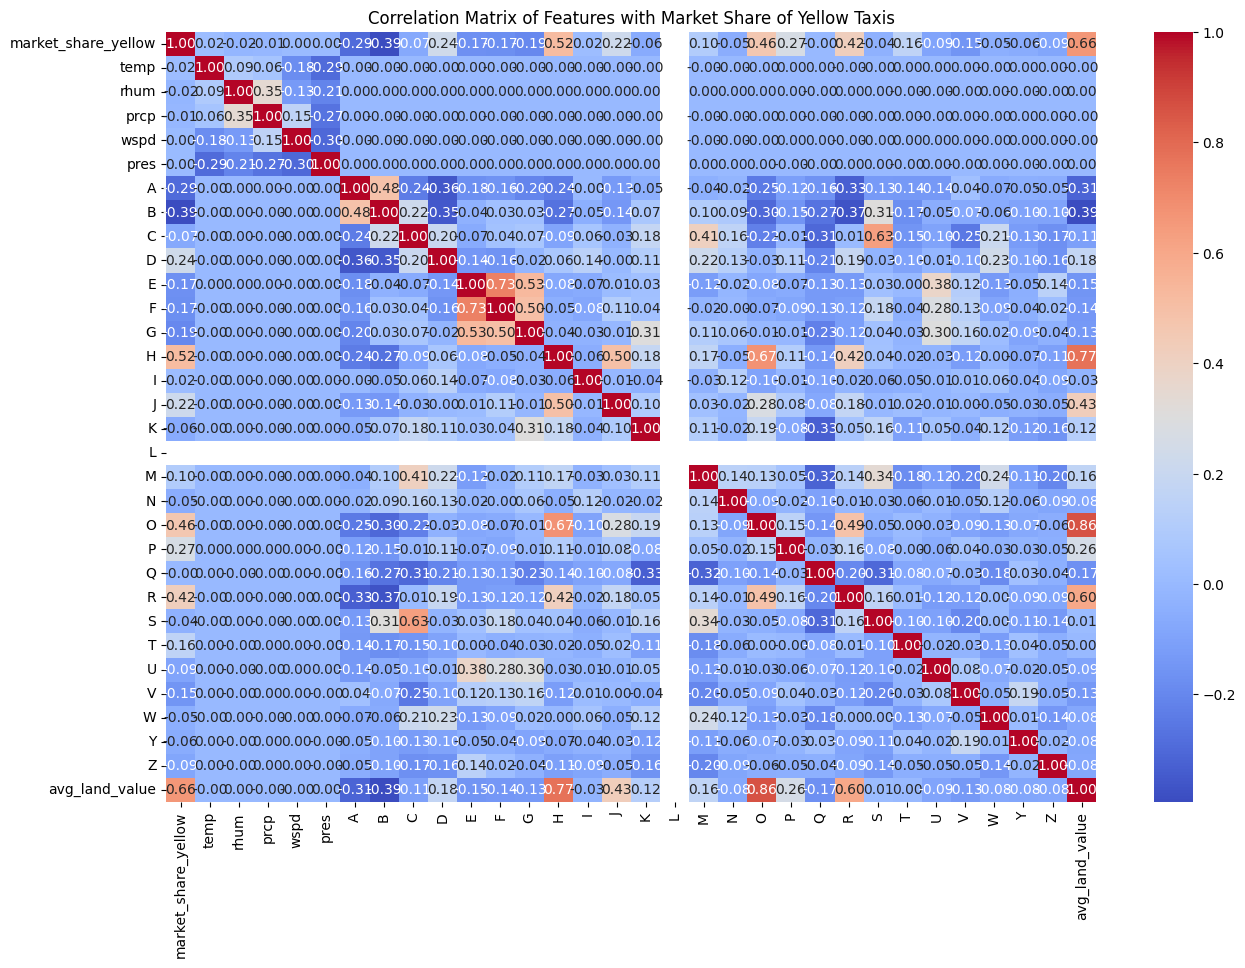

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame if it's not already
final_pdf = final_sdf.toPandas()

# Drop non-numeric columns that we don't want in the correlation matrix
final_pdf = final_pdf.drop(columns=["PULocationID", "date", "hour_bucket"])

# Calculate the correlation matrix
corr_matrix = final_pdf.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Set the title
plt.title('Correlation Matrix of Features with Market Share of Yellow Taxis')

# Display the heatmap
plt.show()


In [44]:
# Drop the 'L' column from the final DataFrame
final_sdf = final_sdf.drop("L")

# Show the first row to verify
final_sdf.show(1, vertical=True, truncate=False)

-RECORD 0---------------------------------
 PULocationID        | 261                
 date                | 2023-11-01         
 hour_bucket         | 0                  
 market_share_yellow | 5.555555555555555  
 temp                | 9.1                
 rhum                | 57.666666666666664 
 prcp                | 0.0333333333333333 
 wspd                | 6.133333333333333  
 pres                | 1016.2666666666668 
 A                   | 0.0                
 B                   | 0.0                
 C                   | 0.2234605401704661 
 D                   | 4.978052595773446  
 E                   | 0.0                
 F                   | 0.0                
 G                   | 12.165145008861291 
 H                   | 3.1790154216804827 
 I                   | 0.0                
 J                   | 0.0                
 K                   | 2.2327421472490996 
 M                   | 7.326273187768384  
 N                   | 0.1998882047326663 
 O         

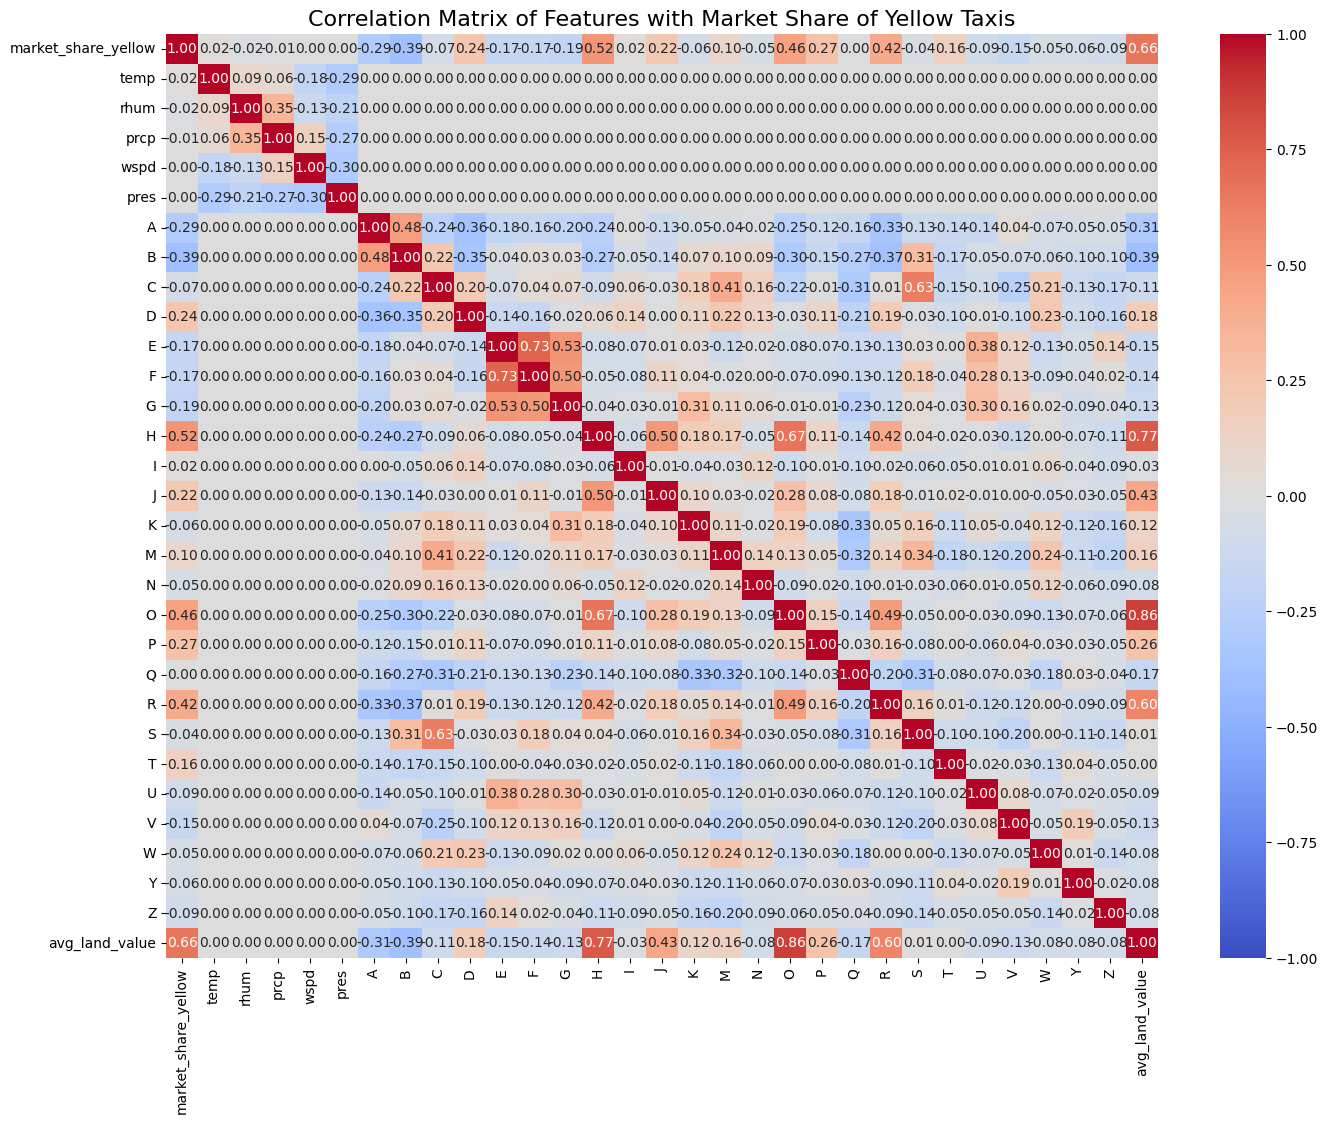

In [45]:
# Remove the non-numeric columns
numeric_cols = final_sdf.drop("PULocationID", "date", "hour_bucket")

# Compute the correlation matrix
correlation_matrix = numeric_cols.toPandas().corr()

# Round the values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)

# Replace small values with 0 for a cleaner look
correlation_matrix[correlation_matrix.abs() < 0.01] = 0

# Set up the figure size
plt.figure(figsize=(16, 12))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": 10}, fmt='.2f')

# Set the title
plt.title("Correlation Matrix of Features with Market Share of Yellow Taxis", fontsize=16)

# Display the plot
plt.show()

# Customized correlation matrix for better interpretation

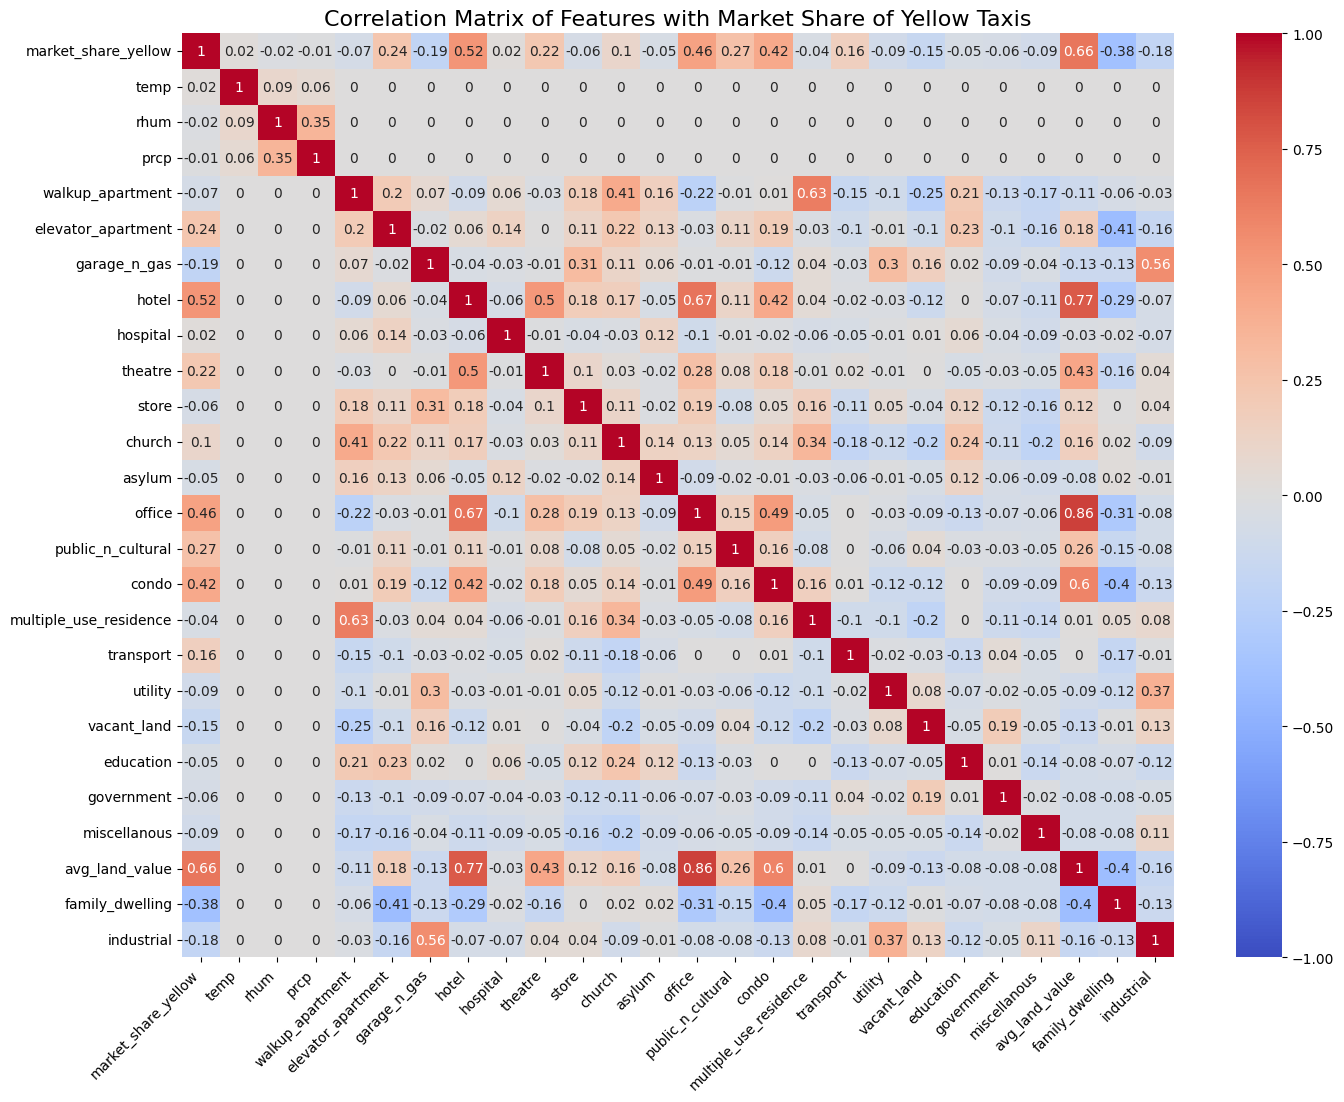

In [46]:
# Step 1: Drop the columns wspd, pres, Q as they have 0 correlation with our target
final_sdf = final_sdf.drop("wspd", "pres", "Q")

# Step 2: Create new columns by summing existing columns
final_sdf = final_sdf.withColumn("family_dwelling", F.col("A") + F.col("B"))
final_sdf = final_sdf.withColumn("industrial", F.col("E") + F.col("F"))

# Step 3: Rename columns
final_sdf = final_sdf.withColumnRenamed("C", "walkup_apartment") \
                     .withColumnRenamed("D", "elevator_apartment") \
                     .withColumnRenamed("G", "garage_n_gas") \
                     .withColumnRenamed("H", "hotel") \
                     .withColumnRenamed("I", "hospital") \
                     .withColumnRenamed("J", "theatre") \
                     .withColumnRenamed("K", "store") \
                     .withColumnRenamed("M", "church") \
                     .withColumnRenamed("N", "asylum") \
                     .withColumnRenamed("O", "office") \
                     .withColumnRenamed("P", "public_n_cultural") \
                     .withColumnRenamed("R", "condo") \
                     .withColumnRenamed("S", "multiple_use_residence") \
                     .withColumnRenamed("T", "transport") \
                     .withColumnRenamed("U", "utility") \
                     .withColumnRenamed("V", "vacant_land") \
                     .withColumnRenamed("W", "education") \
                     .withColumnRenamed("Y", "government") \
                     .withColumnRenamed("Z", "miscellanous")

final_sdf = final_sdf.drop("A", "B", "E", "F")

# Step 4: Redo the visualization

# Drop non-numeric columns for correlation matrix calculation
numeric_cols = final_sdf.drop("PULocationID", "date", "hour_bucket")

# Convert to Pandas DataFrame for correlation matrix computation
final_df = numeric_cols.toPandas()

# Compute the correlation matrix
correlation_matrix = final_df.corr()

# Round the values to 2 decimal places
correlation_matrix = correlation_matrix.round(2)

# Replace small values with 0 for a cleaner look
correlation_matrix[correlation_matrix.abs() < 0.01] = 0

# Set up the figure size
plt.figure(figsize=(16, 12))

# Create the heatmap
sns.heatmap( correlation_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot_kws={"size": 10},
    fmt='.2g'
)

# Adjust the rotation of the x-axis (column) labels
plt.xticks(rotation=45, ha='right')

# Set the title
plt.title("Correlation Matrix of Features with Market Share of Yellow Taxis", fontsize=16)

# Save the plot as image in ../plots directory
plt.savefig('../plots/correlation_matrix_yellow_taxis.png', format='png', dpi=300)

# Display the plot
plt.show()

## Calculate yellow taxis share by location

In [47]:
# Group yellow_taxi_sdf_full by PULocationID and sum the total_yellow
yellow_grouped_sdf = yellow_taxi_sdf_full.groupBy("PULocationID").agg(F.sum("total_yellow").alias("total_yellow"))

# Group hvfhv_sdf_full by PULocationID and sum the total_hvfhv
hvfhv_grouped_sdf = hvfhv_sdf_full.groupBy("PULocationID").agg(F.sum("total_hvfhv").alias("total_hvfhv"))

# View yellow trip by region
yellow_grouped_sdf.show(100, truncate=False)

+------------+------------+
|PULocationID|total_yellow|
+------------+------------+
|26          |108         |
|29          |67          |
|191         |103         |
|65          |9485        |
|222         |44          |
|243         |1507        |
|19          |125         |
|54          |210         |
|167         |144         |
|155         |156         |
|113         |296017      |
|112         |1755        |
|241         |84          |
|237         |1037866     |
|22          |62          |
|198         |178         |
|196         |648         |
|130         |1858        |
|77          |42          |
|7           |6933        |
|184         |19          |
|34          |229         |
|188         |376         |
|202         |419         |
|228         |297         |
|126         |80          |
|262         |273421      |
|94          |52          |
|149         |42          |
|50          |113971      |
|229         |387452      |
|190         |253         |
|136         |106   

In [48]:
# View hvfhv trip by regions
hvfhv_grouped_sdf.show(100, truncate=False)

+------------+-----------+
|PULocationID|total_hvfhv|
+------------+-----------+
|26          |743271     |
|29          |256554     |
|191         |388282     |
|65          |658756     |
|222         |167201     |
|243         |741653     |
|54          |80072      |
|19          |118932     |
|167         |512637     |
|113         |922697     |
|112         |1279905    |
|155         |386690     |
|241         |522382     |
|237         |1180908    |
|22          |465397     |
|198         |842817     |
|130         |1012432    |
|196         |340366     |
|7           |1359564    |
|77          |405275     |
|184         |26471      |
|34          |121749     |
|188         |1042765    |
|228         |651950     |
|126         |425865     |
|202         |99194      |
|262         |534546     |
|50          |821430     |
|149         |329522     |
|94          |293744     |
|229         |862780     |
|110         |211        |
|190         |83335      |
|57          |29501      |
|

In [49]:
# Merge the two DataFrames on PULocationID
yellow_hvfhv_merged_sdf = yellow_grouped_sdf.join(hvfhv_grouped_sdf, on="PULocationID", how="inner")

# Calculate yellow_share
yellow_hvfhv_merged_sdf = yellow_hvfhv_merged_sdf.withColumn(
    "yellow_share", 
    (F.col("total_yellow") / (F.col("total_yellow") + F.col("total_hvfhv")) * 100)
)

# Select only PULocationID and yellow_share
yellow_hvfhv_merged_sdf = yellow_hvfhv_merged_sdf.select("PULocationID", "yellow_share")

# Show the result of yellow_share per location
yellow_hvfhv_merged_sdf.show(265, truncate=False)

+------------+---------------------+
|PULocationID|yellow_share         |
+------------+---------------------+
|26          |0.014528255439015631 |
|29          |0.026108541389831697 |
|191         |0.026520076727988978 |
|65          |1.419398091407142    |
|222         |0.026308708780531556 |
|243         |0.20278271166370634  |
|54          |0.261577937769363    |
|19          |0.10499172665193982  |
|167         |0.028082163730715454 |
|113         |24.289291827286796   |
|112         |0.13693179158279106  |
|155         |0.04032612460772504  |
|241         |0.01607760122189769  |
|237         |46.776553177565624   |
|22          |0.013320185021666785 |
|198         |0.02111519048155683  |
|130         |0.18318232458172712  |
|196         |0.19002152404300116  |
|7           |0.5073556692769907   |
|77          |0.010362259663423938 |
|184         |0.07172517931294828  |
|34          |0.1877387725655446   |
|188         |0.03604498337233413  |
|228         |0.04553489705586994  |
|

# Visualization for yellow taxi share per location 

In [50]:
import geopandas as gpd
import folium
import numpy as np

# Load the yellow_share DataFrame 
yellow_hvfhv_merged_df = yellow_hvfhv_merged_sdf.toPandas()

# Load the taxi zones shapefile and lookup CSV
sf = gpd.read_file("../data/raw/taxi_zones/taxi_zones.shp")
zone = pd.read_csv("../data/raw/taxi_zones/taxi_zone_lookup.csv")

# Reproject the geometry to WGS84 (Longitude/Latitude)
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Merge the data on PULocationID
gdf = gpd.GeoDataFrame(pd.merge(yellow_hvfhv_merged_df, sf, left_on='PULocationID', right_on='LocationID')) \
                        .drop('LocationID',axis=1)

# Convert the merged GeoDataFrame to GeoJSON format for Folium
geoJSON = gdf[['PULocationID','geometry']].to_json()

In [51]:
from folium import Map, TileLayer, Choropleth, LayerControl
import numpy as np

# Create the base map
m = Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
TileLayer('CartoDB positron', name="Light Map", control=False).add_to(m)

# Create more bins to capture finer differences, particularly in the lower range
bins = np.linspace(gdf['yellow_share'].min(), gdf['yellow_share'].max(), num=200)

# Create the Choropleth map with a standard color brewer palette
Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=gdf,
    columns=["PULocationID", "yellow_share"],
    key_on="properties.PULocationID",
    fill_color='YlOrRd',  # Using a standard color brewer palette
    fill_opacity=0.9,
    line_opacity=0.4,
    legend_name="Yellow Taxi Market Share",
    bins=bins,  # Increase number of bins for finer color gradients
    nan_fill_color="white",
    nan_fill_opacity=0.6
).add_to(m)

# Add layer control and save the map
LayerControl().add_to(m)
fpth = "../plots/yellow_share_map_fine_colors.html"
m.save(fpth)

print(f"Map saved to: {fpth}")

Map saved to: ../plots/yellow_share_map_fine_colors.html


# Plot for yellow taxi share over hours

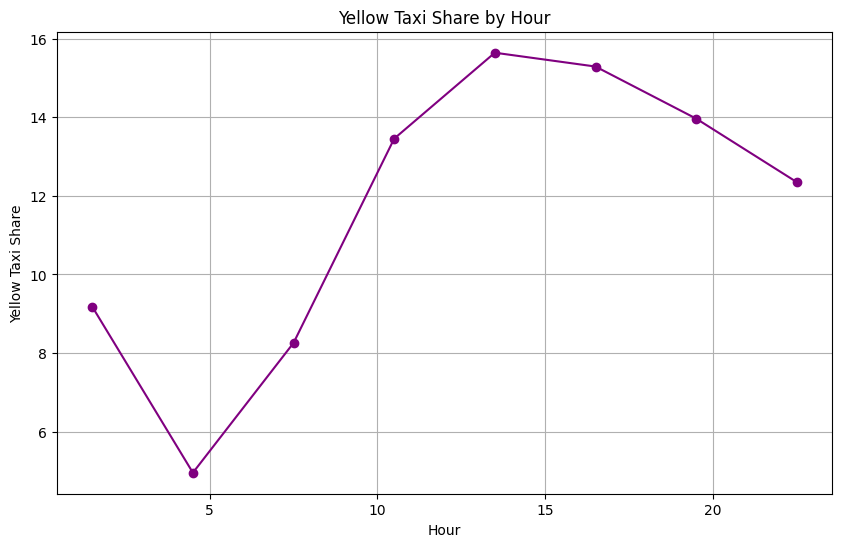

In [52]:
import matplotlib.pyplot as plt

# Group by hour_bucket and sum the values for yellow taxis
yellow_hourly = yellow_taxi_sdf_full.groupBy("hour_bucket").sum("total_yellow").withColumnRenamed("sum(total_yellow)", "total_yellow")

# Group by hour_bucket and sum the values for hvfhv taxis
hvfhv_hourly = hvfhv_sdf_full.groupBy("hour_bucket").sum("total_hvfhv").withColumnRenamed("sum(total_hvfhv)", "total_hvfhv")

# Merge the two DataFrames on hour_bucket
merged_hourly = yellow_hourly.join(hvfhv_hourly, on="hour_bucket", how="inner")

# Calculate the yellow taxi share by hour bucket
merged_hourly = merged_hourly.withColumn("yellow_share", merged_hourly["total_yellow"] / (merged_hourly["total_yellow"] + merged_hourly["total_hvfhv"]) * 100)

# Convert to Pandas for plotting
hourly_df = merged_hourly.toPandas()

# Adjust the hour_bucket by adding 1.5 for better representation
hourly_df["hour_bucket"] = hourly_df["hour_bucket"] + 1.5

# Ensure the data is sorted by the adjusted hour_bucket
hourly_df_sorted = hourly_df.sort_values(by="hour_bucket")

# Plot with sorted data
plt.figure(figsize=(10, 6))
plt.plot(hourly_df_sorted["hour_bucket"], hourly_df_sorted["yellow_share"], marker='o', linestyle='-', color='purple')
plt.xlabel('Hour')
plt.ylabel('Yellow Taxi Share')
plt.title('Yellow Taxi Share by Hour')
plt.grid(True)

# Save the plot as image
plt.savefig('../plots/yellow_taxi_share_by_hours.png', format='png', dpi=300)

plt.show()

# Plot for yellow taxis share over week day

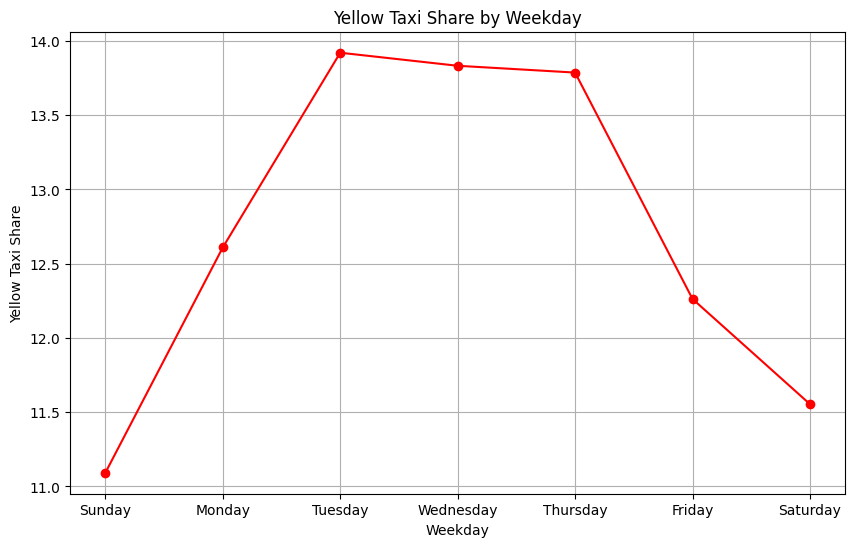

In [53]:
from pyspark.sql.functions import dayofweek

# Add a new column 'weekday' based on the date, where 1=Sunday, 2=Monday, ..., 7=Saturday
yellow_taxi_sdf_full = yellow_taxi_sdf_full.withColumn("weekday", dayofweek("date"))
hvfhv_sdf_full = hvfhv_sdf_full.withColumn("weekday", dayofweek("date"))

# Group by weekday and sum the values for yellow taxis
yellow_weekday = yellow_taxi_sdf_full.groupBy("weekday").sum("total_yellow").withColumnRenamed("sum(total_yellow)", "total_yellow")

# Group by weekday and sum the values for hvfhv taxis
hvfhv_weekday = hvfhv_sdf_full.groupBy("weekday").sum("total_hvfhv").withColumnRenamed("sum(total_hvfhv)", "total_hvfhv")

# Merge the two DataFrames on weekday
merged_weekday = yellow_weekday.join(hvfhv_weekday, on="weekday", how="inner")

# Calculate the yellow taxi share by weekday
merged_weekday = merged_weekday.withColumn("yellow_share", merged_weekday["total_yellow"] / (merged_weekday["total_yellow"] + merged_weekday["total_hvfhv"]) * 100)

# Convert to Pandas for plotting
weekday_df = merged_weekday.toPandas()

# Map the weekdays to their names for better readability
weekday_map = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}
weekday_df["weekday"] = weekday_df["weekday"].map(weekday_map)

# Ensure the data is sorted by weekday according to the desired order
weekday_df_sorted = weekday_df.set_index("weekday").loc[list(weekday_map.values())].reset_index()

# Plot with sorted data
plt.figure(figsize=(10, 6))
plt.plot(weekday_df_sorted["weekday"], weekday_df_sorted["yellow_share"], marker='o', linestyle='-', color='red')
plt.xlabel('Weekday')
plt.ylabel('Yellow Taxi Share')
plt.title('Yellow Taxi Share by Weekday')
plt.grid(True)

# Save the plot as image
plt.savefig('../plots/yellow_taxi_share_by_week_day.png', format='png', dpi=300)

plt.show()

# Plot for yellow taxis share over months

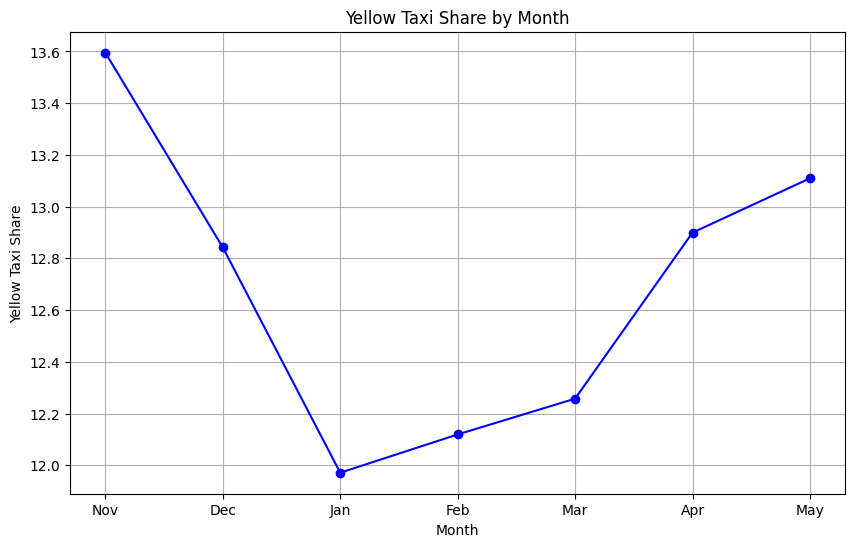

In [54]:
from pyspark.sql.functions import month

# Add a new column 'month' based on the date
yellow_taxi_sdf_full = yellow_taxi_sdf_full.withColumn("month", month("date"))
hvfhv_sdf_full = hvfhv_sdf_full.withColumn("month", month("date"))

# Group by month and sum the values for yellow taxis
yellow_monthly = yellow_taxi_sdf_full.groupBy("month").sum("total_yellow").withColumnRenamed("sum(total_yellow)", "total_yellow")

# Group by month and sum the values for hvfhv taxis
hvfhv_monthly = hvfhv_sdf_full.groupBy("month").sum("total_hvfhv").withColumnRenamed("sum(total_hvfhv)", "total_hvfhv")

# Merge the two DataFrames on month
merged_monthly = yellow_monthly.join(hvfhv_monthly, on="month", how="inner")

# Calculate the yellow taxi share by month
merged_monthly = merged_monthly.withColumn("yellow_share", merged_monthly["total_yellow"] / (merged_monthly["total_yellow"] + merged_monthly["total_hvfhv"]) * 100)

# Convert to Pandas for plotting
monthly_df = merged_monthly.toPandas()

# Map the month numbers to their corresponding names
month_map = {11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May'}
monthly_df["month"] = monthly_df["month"].map(month_map)

# Ensure the data is sorted in the desired order
ordered_months = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
monthly_df_sorted = monthly_df.set_index("month").loc[ordered_months].reset_index()

# Plot with sorted data
plt.figure(figsize=(10, 6))
plt.plot(monthly_df_sorted["month"], monthly_df_sorted["yellow_share"], marker='o', linestyle='-', color='blue')
plt.xlabel('Month')
plt.ylabel('Yellow Taxi Share')
plt.title('Yellow Taxi Share by Month')
plt.grid(True)

# Save the plot as image
plt.savefig('../plots/yellow_taxi_share_by_month.png', format='png', dpi=300)

plt.show()

# Export final aggregated and curated data

In [55]:
import os
from pyspark.sql.functions import min, max, col, dayofweek, month

# Add a column for the day of the week (1 = Sunday, 7 = Saturday)
final_sdf = final_sdf.withColumn("day_of_week", dayofweek("date"))

# Add a column for the month (1 = January, 12 = December)
final_sdf = final_sdf.withColumn("month", month("date"))

# List of columns to normalize
cols_to_normalize = [
    'temp', 'rhum', 'prcp', 'walkup_apartment', 'elevator_apartment', 'garage_n_gas', 
    'hotel', 'hospital', 'theatre', 'store', 'church', 'asylum', 'office', 'public_n_cultural', 
    'condo', 'multiple_use_residence', 'transport', 'utility', 'vacant_land', 'education', 
    'government', 'miscellanous', 'avg_land_value', 'family_dwelling', 'industrial'
]

# Normalize columns
for col_name in cols_to_normalize:
    min_val = final_sdf.agg({col_name: "min"}).collect()[0][0]
    max_val = final_sdf.agg({col_name: "max"}).collect()[0][0]
    final_sdf = final_sdf.withColumn(col_name, (col(col_name) - min_val) / (max_val - min_val))

# Now, export the DataFrame with the new columns
output_dir = '../data'

file_name = 'final_data_for_modeling.parquet'

# Export the final_sdf in Parquet format
final_sdf.write.parquet(os.path.join(output_dir, file_name), mode='overwrite')

print(f"Data has been successfully exported to {os.path.join(output_dir, file_name)} in Parquet format.")

24/08/26 15:53:59 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Data has been successfully exported to ../data/final_data_for_modeling.parquet in Parquet format.
